In [116]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


import numpy as np

def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示

    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

def create_contexts_target(corpus, window_size=1):
    '''生成上下文和目标词

    :param corpus: 语料库（单词ID列表）
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax的输出
        self.t = None  # 监督标签

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 在监督标签为one-hot向量的情况下，转换为正确解标签的索引
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx




def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x
    
def cross_entropy_error(y, t):
    print(y,t)
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 在监督标签为one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    # np.log(...)方法返回的是新数组
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    


转换思路看当前目录下的图片

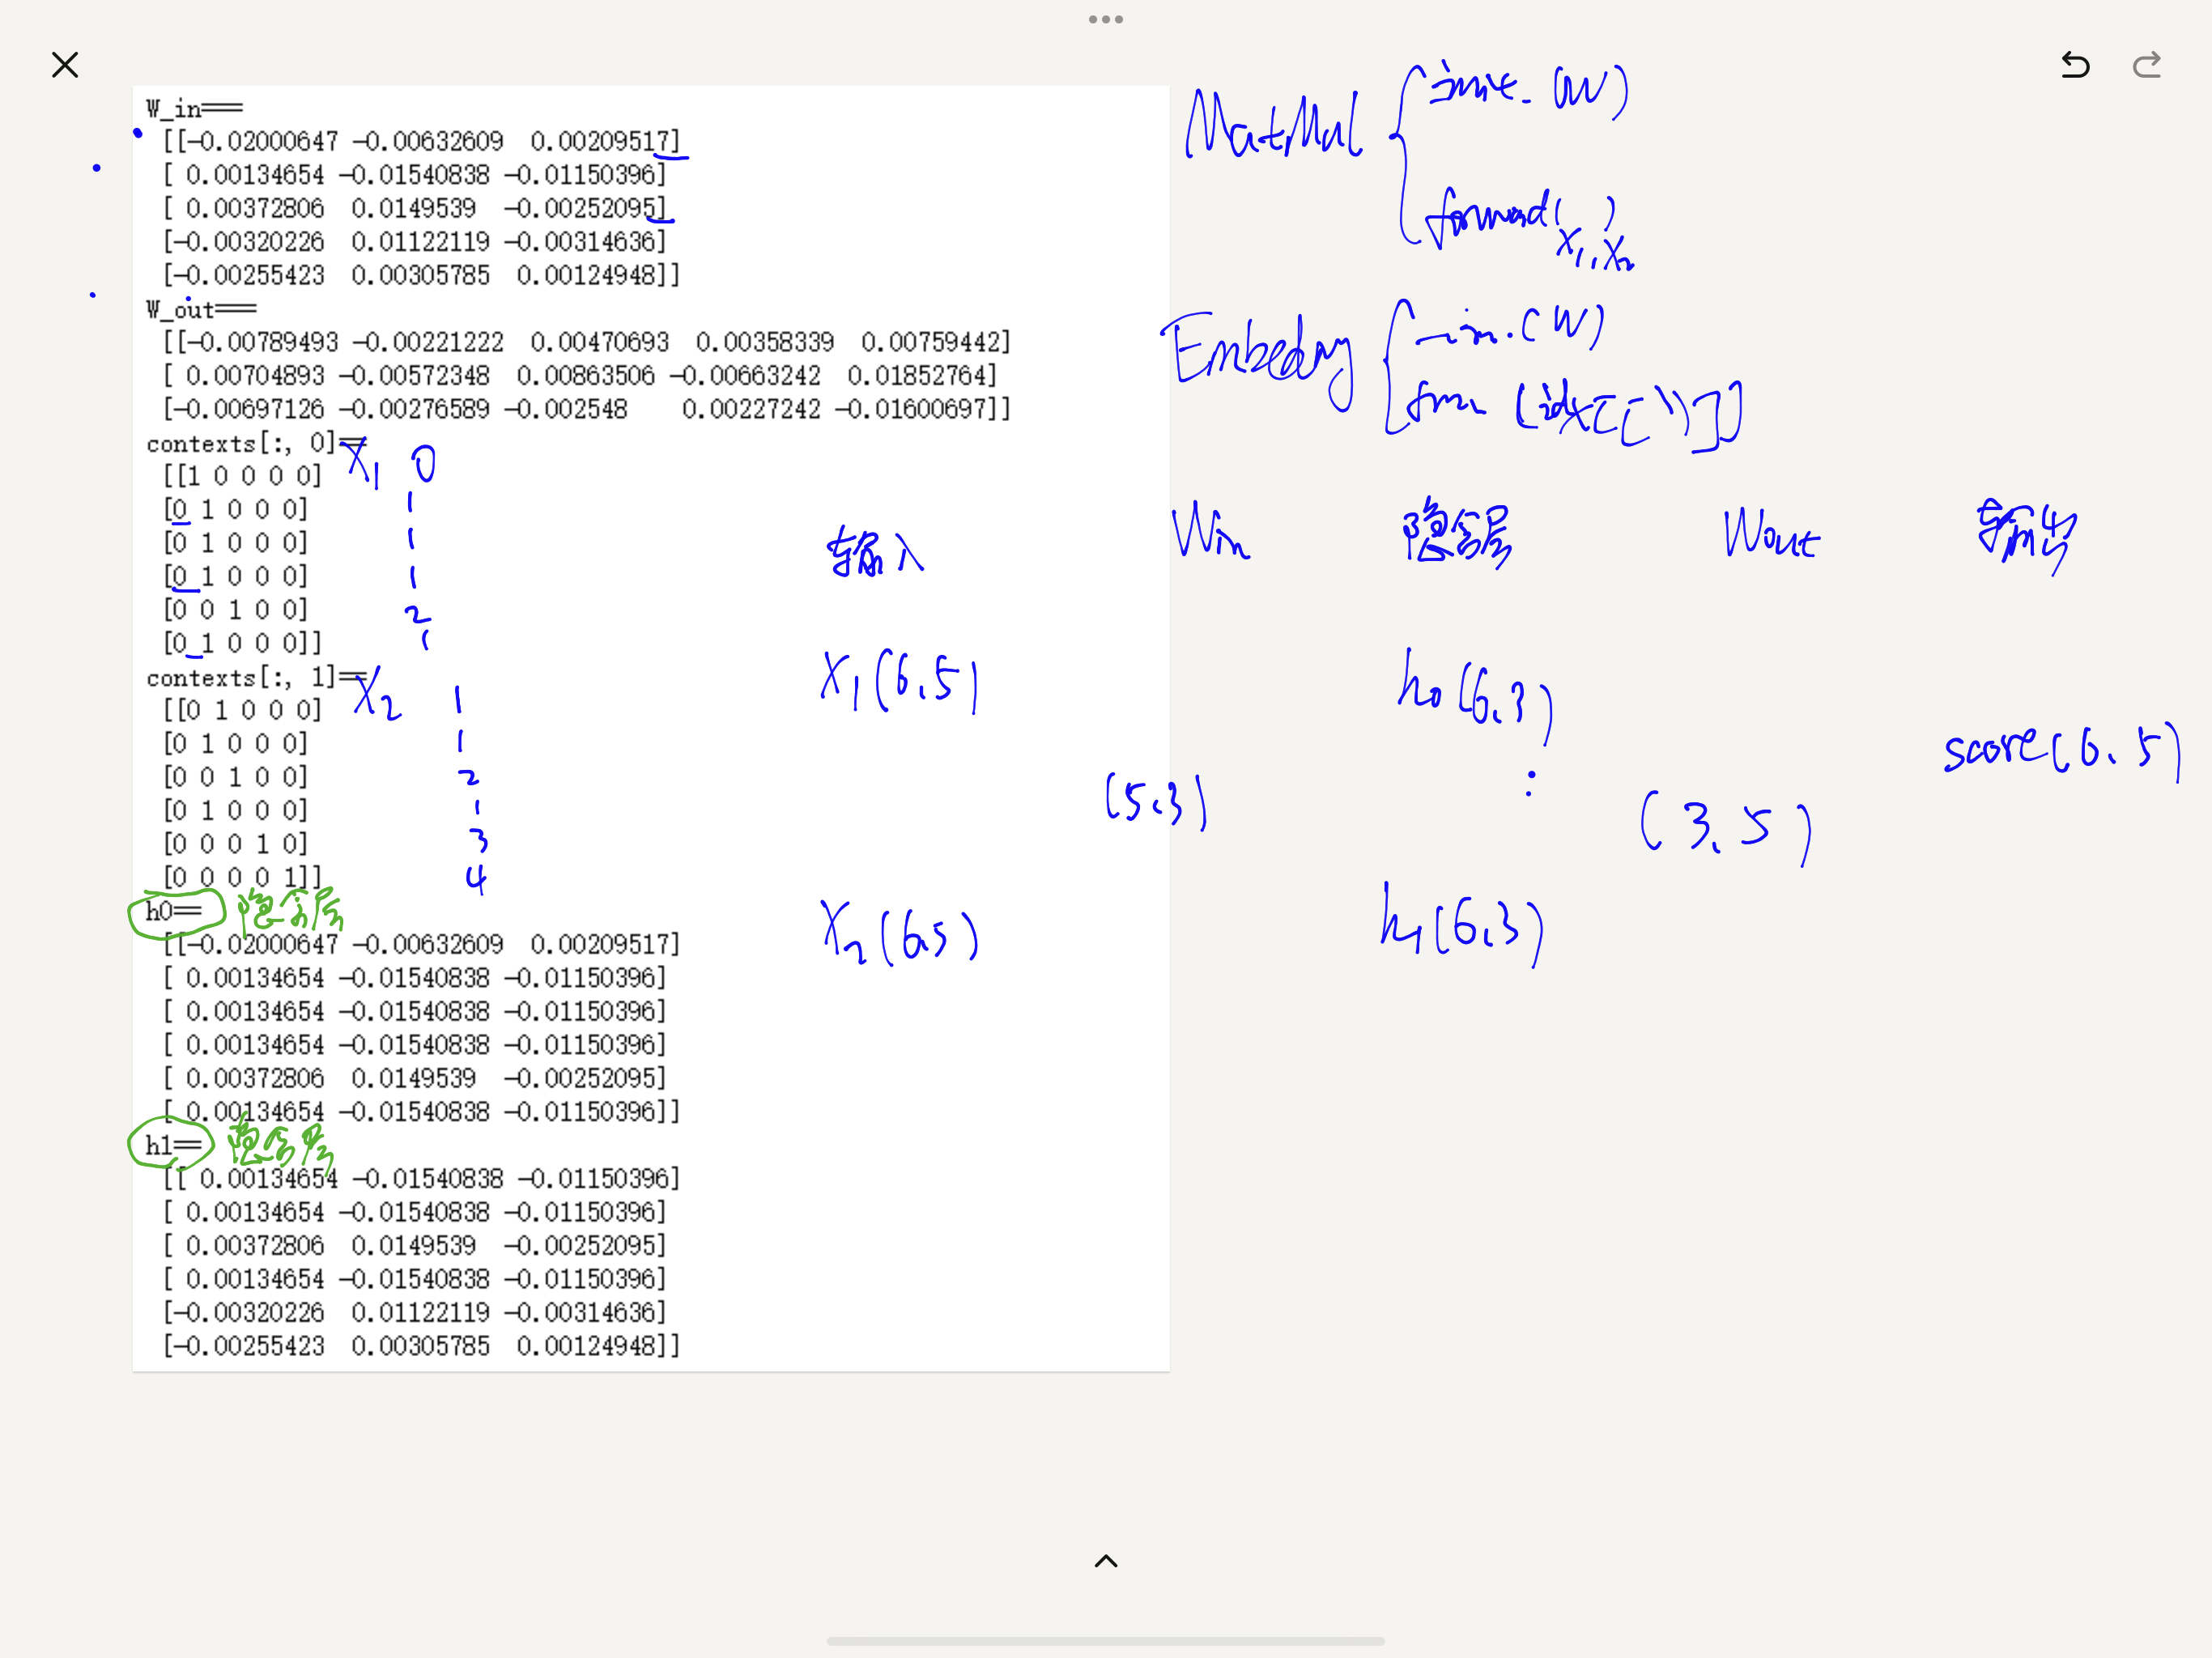

In [117]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        print('embedding forward',W,idx)
        print('W[idx]==',W[idx])
        
        out = W[idx]
        return out

    def backward(self, dout):
        print('self.grads=11111==',self.grads,self.idx)
        dW, = self.grads
        dW[...] = 0 #dW[...] = 0 将 dW（即全零矩阵）重置为全零，确保每次进行反向传播时梯度是清零的。
        np.add.at(dW, self.idx, dout)
        return dW

In [118]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        print(V, H)
        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        print('W_in===\n',W_in)
        print('W_out===\n',W_out)
        
        # 生成层
        self.in_layer0 = Embedding(W_in)
        self.in_layer1 = Embedding(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        idx1 = contexts[:, 0].argmax(axis=1)
        idx2 = contexts[:, 1].argmax(axis=1)
        out = np.array([idx1,idx2])
        print('out===', out)
        h0 = self.in_layer0.forward(out[0, :])
        h1 = self.in_layer1.forward(out[1, :])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        print('score===\n',score)
        print('target===\n',target)
        loss = self.loss_layer.forward(score, target)
        print('loss',loss)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        print('da==',da)
        in_layer1_da = self.in_layer1.backward(da)
        in_layer2_da = self.in_layer0.backward(da)
        print('in_layer1_da==',in_layer1_da)
        print('in_layer2_da==',in_layer2_da)
        return None


In [119]:
text = 'You say say say I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
# print(corpus, word_to_id, id_to_word,'==corpus, word_to_id, id_to_word')
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
# print(contexts,target)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print('contexts===',contexts)
# idx1 = contexts[:, 0].argmax(axis=1)
# idx2 = contexts[:, 1].argmax(axis=1)
# print('idx===',idx2)
hidden_size = 3
model = SimpleCBOW(vocab_size, hidden_size)
model.forward(contexts,target)
model.backward()

contexts=== [[[1 0 0 0 0]
  [0 1 0 0 0]]

 [[0 1 0 0 0]
  [0 1 0 0 0]]

 [[0 1 0 0 0]
  [0 0 1 0 0]]

 [[0 1 0 0 0]
  [0 1 0 0 0]]

 [[0 0 1 0 0]
  [0 0 0 1 0]]

 [[0 1 0 0 0]
  [0 0 0 0 1]]]
5 3
W_in===
 [[-0.00337228 -0.00564716 -0.0085281 ]
 [-0.00617044 -0.00270656  0.00763079]
 [-0.00895784  0.01889686 -0.00323562]
 [-0.01444123  0.00502983 -0.00387476]
 [ 0.01200857 -0.01226196  0.00648106]]
W_out===
 [[ 0.00773472 -0.00883068 -0.00866825 -0.00940271  0.00857344]
 [-0.00166961  0.00868524 -0.01695678  0.00256694  0.00311968]
 [ 0.00635204 -0.001587   -0.01638275  0.02188129  0.00960893]]
out=== [[0 1 1 1 2 1]
 [1 1 2 1 3 4]]
embedding forward [[-0.00337228 -0.00564716 -0.0085281 ]
 [-0.00617044 -0.00270656  0.00763079]
 [-0.00895784  0.01889686 -0.00323562]
 [-0.01444123  0.00502983 -0.00387476]
 [ 0.01200857 -0.01226196  0.00648106]] [0 1 1 1 2 1]
W[idx]== [[-0.00337228 -0.00564716 -0.0085281 ]
 [-0.00617044 -0.00270656  0.00763079]
 [-0.00617044 -0.00270656  0.00763079]
 [-0.00